 # Set operations on  dask bags
 
[Introduction to Dask, by Anderson Banihirwe](https://github.com/andersy005/dask-notebooks)

Dask supports some of the operations we have in mathematical sets, such as union (named concat in dask). 

Set operations are quite straightforward to understand as it work as expected. The only consideration comes from the fact that bags are not real sets, and therefore operations such as the concatenation (union) of bags doesn't remove duplicates. 

In this notebook we will have a brief look at remove(subtract), distinct, and product(cartesian).



## Getting the data and creating the bag



As we did in our first notebook, we will use the reduced dataset (10 percent) provided for the KDD Cup 1999, containing nearly half million network interactions. The file is provided as a Gzip file that we will download locally.

If you previously downloaded this dataset, the following program won't download it again. 

In [1]:
import urllib.request
import os
import pathlib
DATASET_DIR = pathlib.Path('../data')
DATASET_FILEPATH = pathlib.Path('../data/kddcup.data_10_percent.gz')
if not DATASET_DIR.exists():
    os.mkdir(DATA_DIR)
    f = urllib.request.urlretrieve(
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        DATASET_FILEPATH)

In [3]:
import dask
import dask.bag as db
# Progress Bar
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [4]:
raw_data = db.read_text(DATASET_FILEPATH).repartition(4)
# count all 
raw_data_count = raw_data.count().compute()

[########################################] | 100% Completed | 21.7s


## Getting attack interactions using `remove`

For illustrative purposes, imagine we already have our bag with non attack (normal) interactions from some previous analysis.

In [5]:
normal_raw_data = raw_data.filter(lambda x: "normal." in x)

In [6]:
# count normal
normal_raw_data_count = normal_raw_data.count().compute()

[########################################] | 100% Completed | 23.1s


We can obtain attack interactions by subtracting normal ones from the original unfiltered bag as follows.

In [7]:
attack_raw_data = raw_data.remove(lambda x: "normal." in x)

In [8]:
# count attacks
attack_raw_data_count = attack_raw_data.count().compute()

[########################################] | 100% Completed | 26.0s


In [9]:
print("There are {} normal interactions and {} attacks, \
from a total of {} interactions".format(normal_raw_data_count,
                                        attack_raw_data_count, raw_data_count))

There are 97278 normal interactions and 396743 attacks, from a total of 494021 interactions


So now we have two bags, one with normal interactions and another one with attacks.

## Protocol and service combinations using `product`

We can compute the Cartesian product between two bags by using the `product`. It returns all possible pairs of elements between two bags. In our case we will use it to generate all the possible combinations between service and protocol in our network interactions.

First of all we need to isolate each collection of values in two separate bags. For that we will use distinct on the CSV-parsed dataset. From the [dataset description](http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names) we know that protocol is the second column and service is the third (tag is the last one and not the first as appears in the page).


##### Dataset description
`
back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.
duration: continuous.
protocol_type: symbolic.
service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
`


So first, let's get the protocols.


In [10]:
csv_data = raw_data.map(lambda x: x.split(","))
protocols = csv_data.map(lambda x: x[1]).distinct()

In [11]:
protocols.compute()

[########################################] | 100% Completed | 25.3s


['tcp', 'icmp', 'udp']

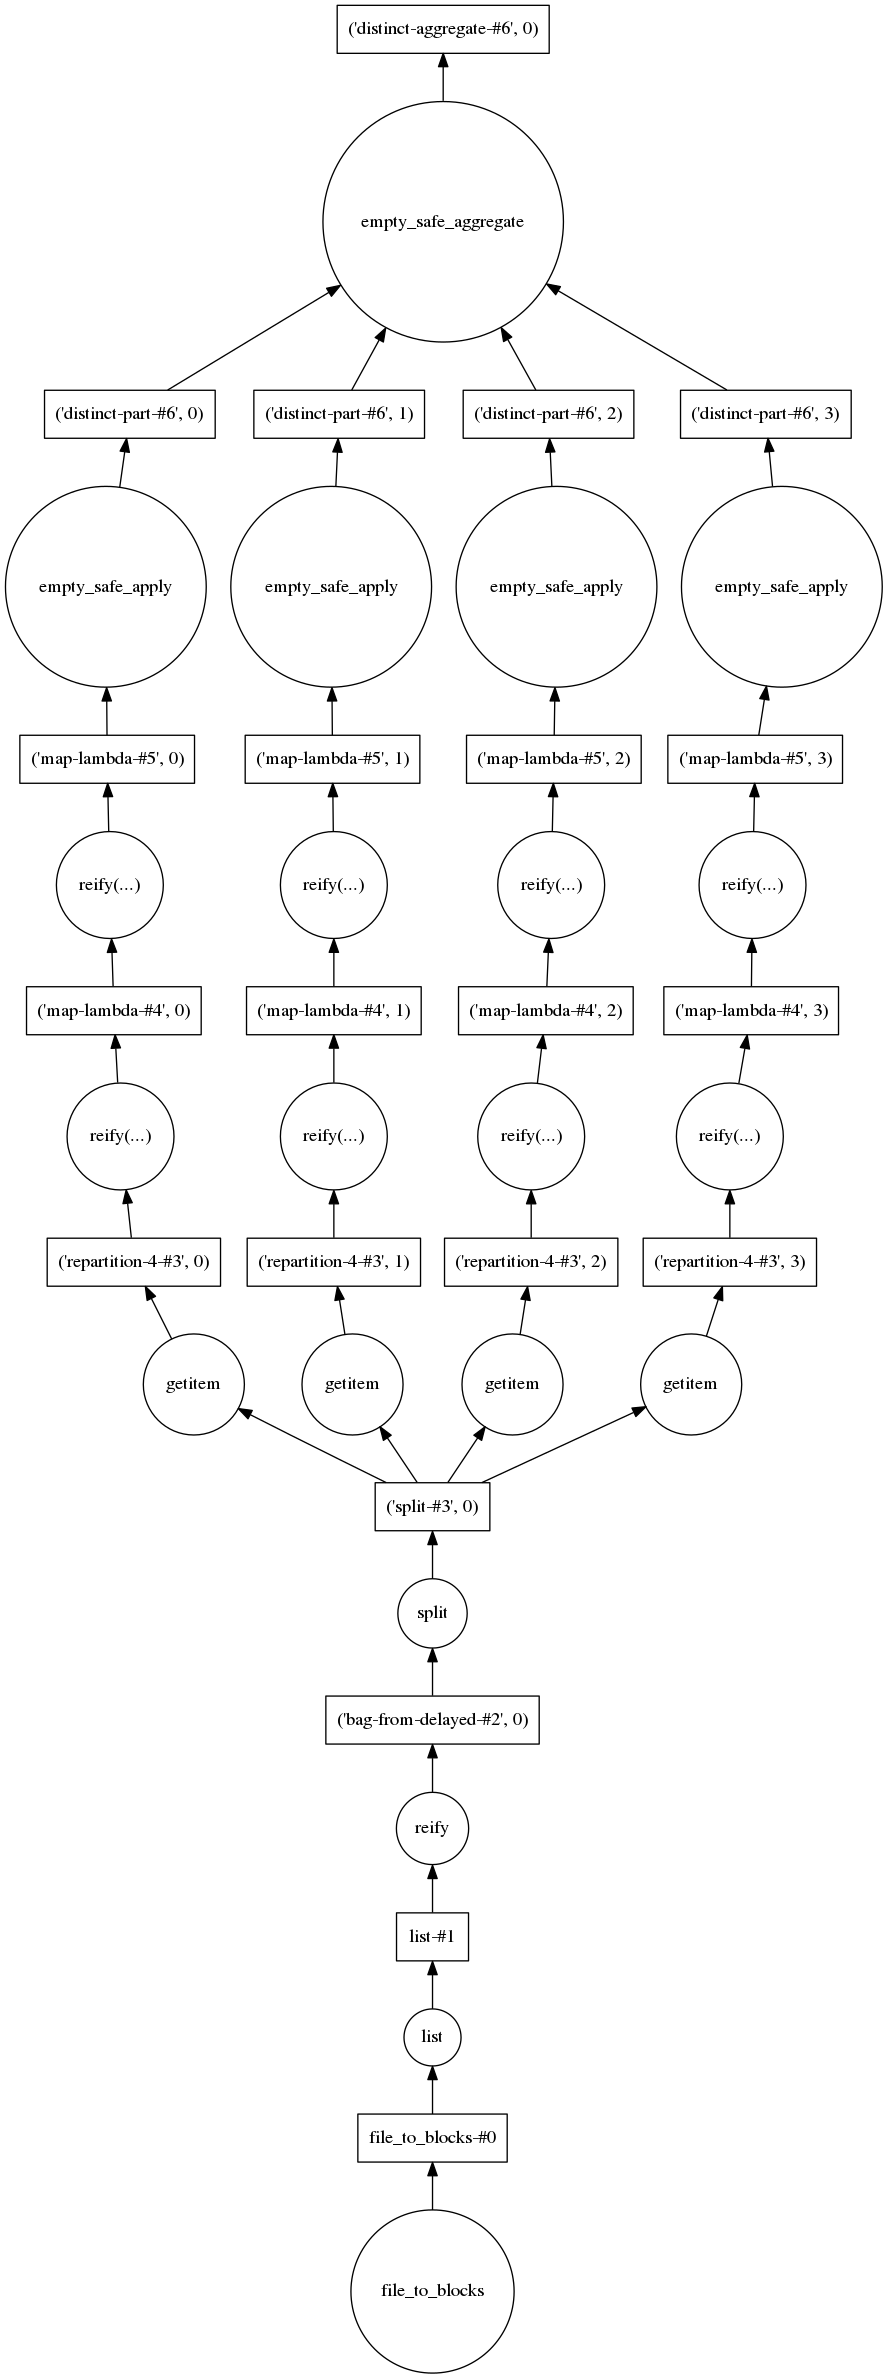

In [12]:
protocols.visualize()

Now we do the same for services.

In [13]:
services = csv_data.map(lambda x: x[2]).distinct()
services.compute()

[########################################] | 100% Completed | 25.9s


['eco_i',
 'exec',
 'bgp',
 'urh_i',
 'shell',
 'time',
 'ftp_data',
 'whois',
 'finger',
 'csnet_ns',
 'hostnames',
 'ntp_u',
 'Z39_50',
 'ctf',
 'remote_job',
 'uucp',
 'X11',
 'vmnet',
 'tim_i',
 'gopher',
 'login',
 'tftp_u',
 'telnet',
 'supdup',
 'private',
 'iso_tsap',
 'netbios_ssn',
 'domain_u',
 'red_i',
 'mtp',
 'printer',
 'pm_dump',
 'systat',
 'rje',
 'name',
 'ftp',
 'smtp',
 'netbios_ns',
 'courier',
 'other',
 'domain',
 'nntp',
 'sunrpc',
 'discard',
 'http',
 'efs',
 'klogin',
 'echo',
 'netbios_dgm',
 'imap4',
 'ssh',
 'http_443',
 'nnsp',
 'daytime',
 'urp_i',
 'auth',
 'ldap',
 'pop_2',
 'netstat',
 'link',
 'uucp_path',
 'sql_net',
 'IRC',
 'kshell',
 'pop_3',
 'ecr_i']

A longer list in this case.

Now we can do the cartesian product.

In [14]:
product = protocols.product(services).compute()
print("There are {} combinations of protocol X service".format(len(product)))

[########################################] | 100% Completed |  6min 18.3s
There are 198 combinations of protocol X service


Obviously, for such small bags it doesn't really make sense to use dask cartesian product. We could have perfectly collected the values after using distinct and do the cartesian product locally. Moreover, distinct and product are expensive operations so they must be used with care when the operating datasets are large.

In [15]:
%load_ext version_information
%version_information dask

Software versions
Python 3.6.4 64bit [GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
IPython 6.2.1
OS Linux 4.13.0 32 generic x86_64 with debian stretch sid
dask 0.17.0
Sat Feb 17 22:31:33 2018 CST